# Data Analytics Group Project

## 1. Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import Image

In [2]:
df = pd.read_excel('two-phase flow correlation data.xlsx')

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True
    
all_data = df[df.columns[1:]].values
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis = 1).copy().values
X = np.array(all_data[real_rows, 1:], dtype = 'float')
y = np.array(all_data[real_rows, 0], dtype = 'float')
y = y.reshape(-1, 1)
x_names = [str(x) for x in df.columns[2:]]
y_name = df.columns[1]

print('X matrix dimensions: {}'.format(X.shape))
print('y matrix dimensions: {}'.format(y.shape))
#print(X)
#print(x_names)

X matrix dimensions: (8057, 7)
y matrix dimensions: (8057, 1)


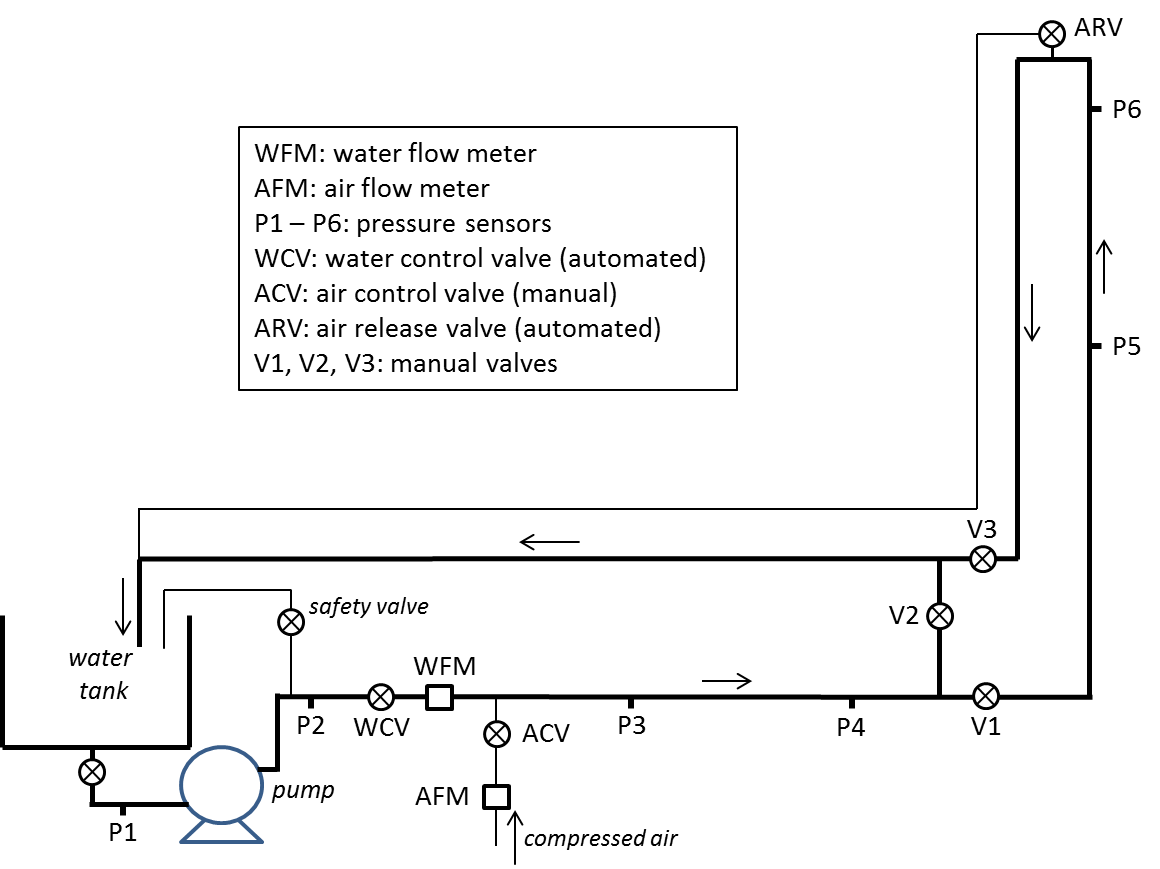

In [3]:
Image(filename='two-phase flow pressure drop.png')

Text(0.5, 0, 'P6 (kPa)')

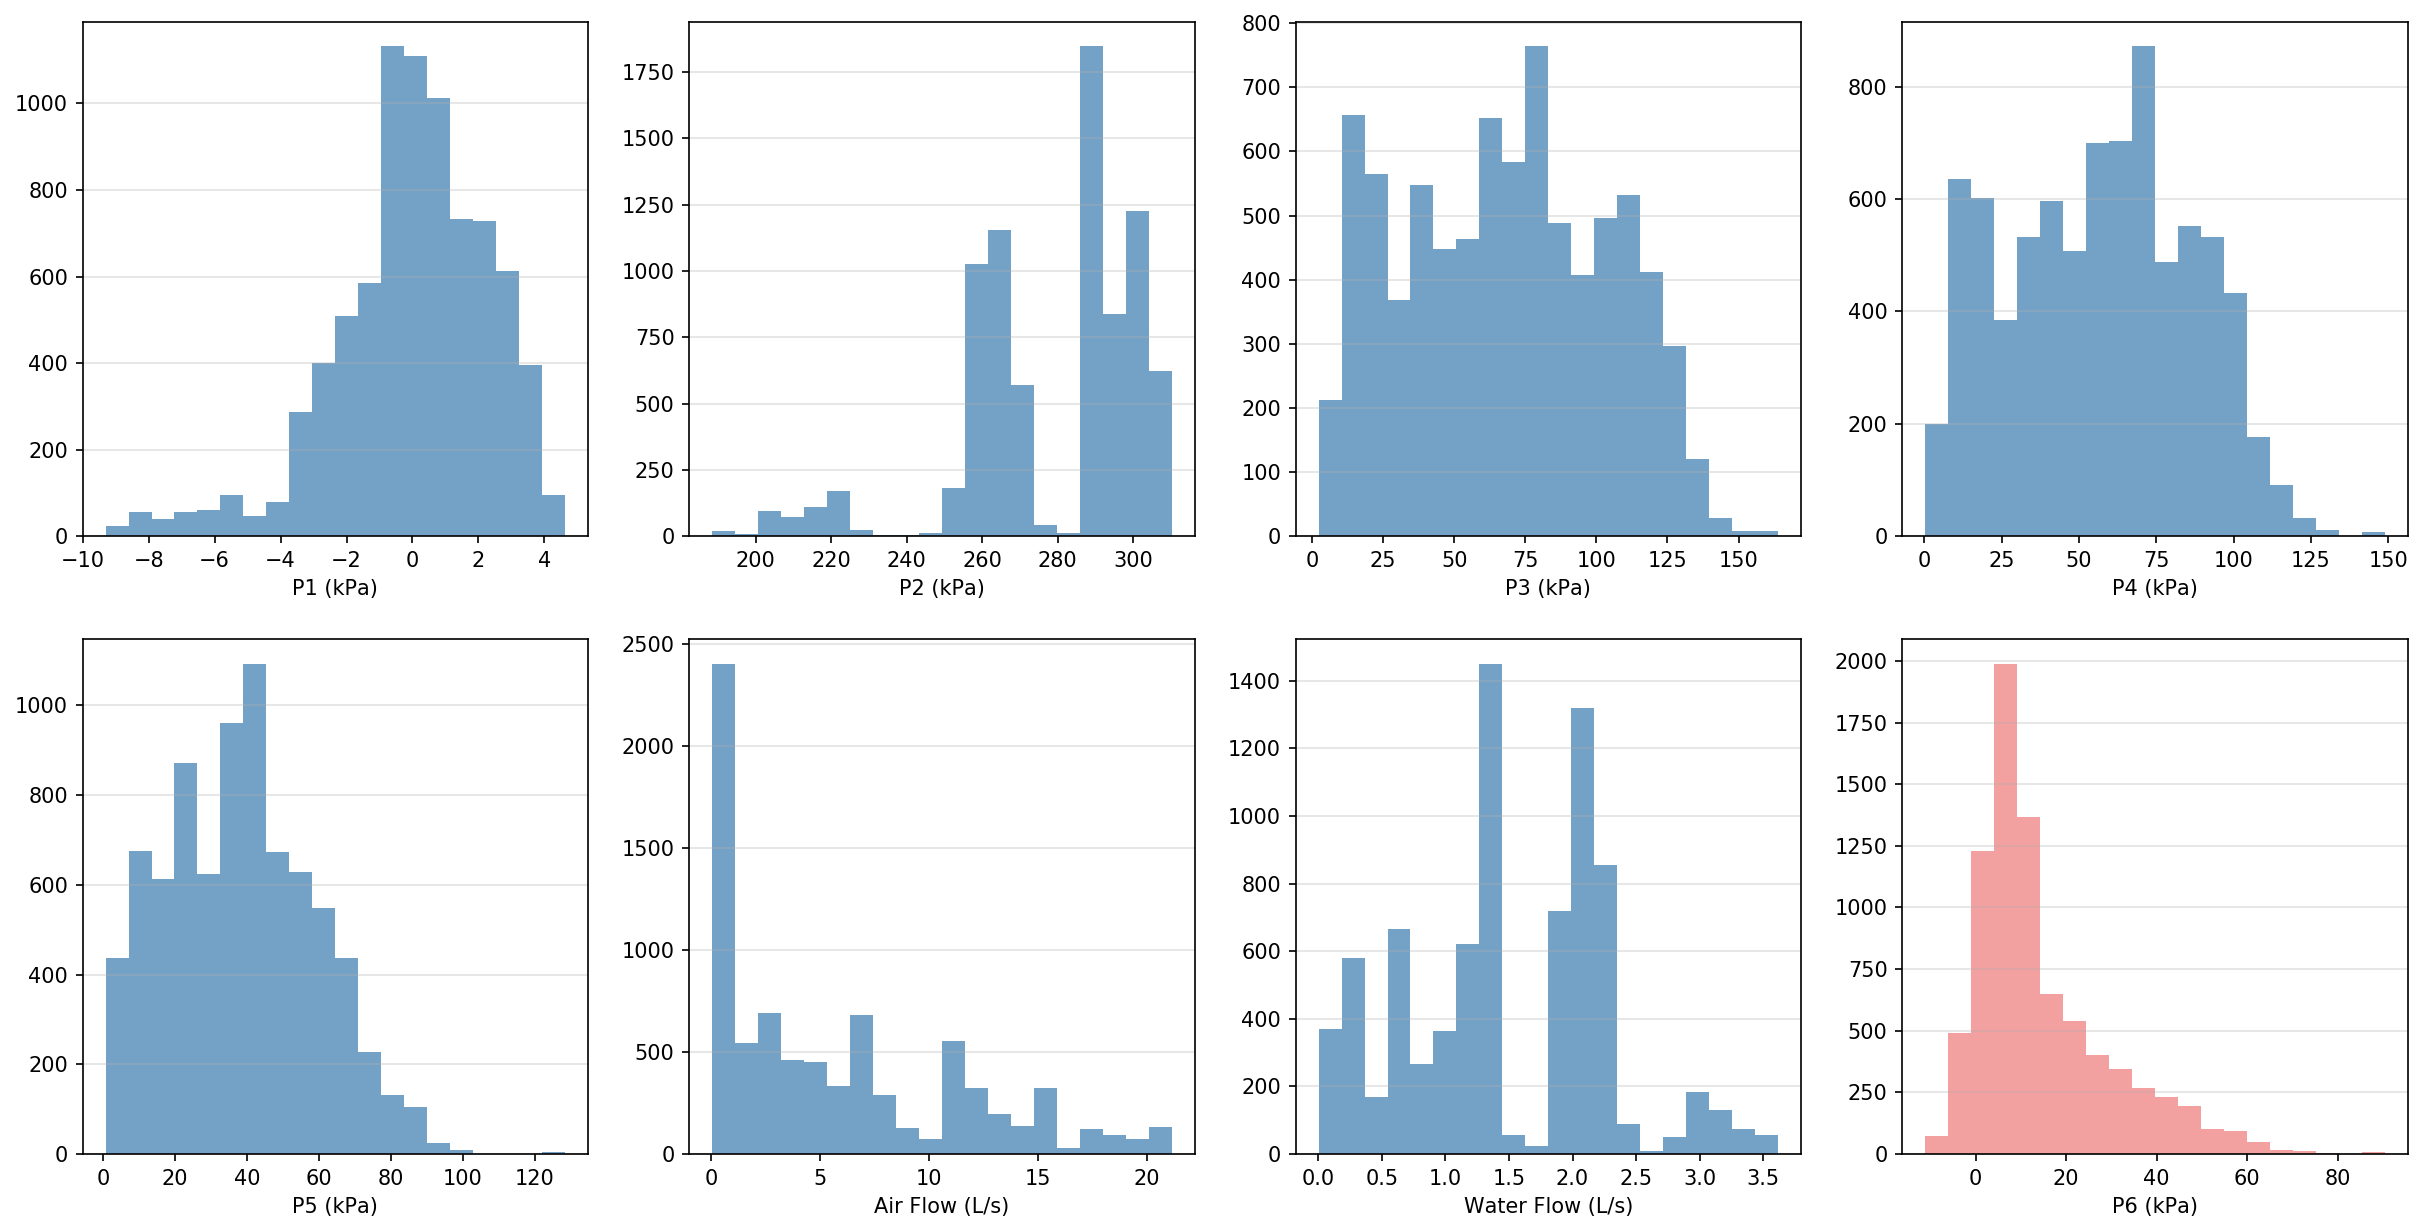

In [19]:
######################################### feature distribution ############################################################

fig, axes = plt.subplots(2, 4, figsize = (20, 10), dpi = 150)
for i in range(2):
    for j in range(4):
        feature = i*4+j
        if feature <= 6:
            axes[i,j].grid(axis='y', linestyle='-', linewidth=1, alpha=0.3)
            axes[i,j].hist(X[:,feature], bins=20, facecolor='steelblue', alpha=0.75)
            axes[i,j].set_xlabel(x_names[feature])
#distribution of target variable
axes[1,-1].grid(axis='y', linestyle='-', linewidth=1, alpha=0.3)
axes[1,-1].hist(y, bins=20, facecolor='lightcoral', alpha=0.75)
axes[1,-1].set_xlabel(y_name)

<font color=blue>**Data distributions**</font>

1. "normal": P1, P3, P4
2. "random": P2, Air Flow, Water Flow
3. "damped": P5, P6

## 2. Data management and exploratory analysis

In [5]:
############################################ data preprocessing ############################################################

################### feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
print('Total data size = {}'. format(X_scaled.shape))

################### data spliting
from sklearn.model_selection import train_test_split

# 70%-training, 15%-validation, 15%-test
X_train, X_, y_train, y_ = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)
X_validation, X_test, y_validation, y_test = train_test_split(X_, y_, test_size=0.5, shuffle=True)
print('Train size = {}, Validation size = {}, Test size = {}'.format(y_train.shape, y_validation.shape, y_test.shape))

Total data size = (8057, 7)
Train size = (5639, 1), Validation size = (1209, 1), Test size = (1209, 1)


[Text(0, 0.5, 'P1'),
 Text(0, 1.5, 'P2'),
 Text(0, 2.5, 'P3'),
 Text(0, 3.5, 'P4'),
 Text(0, 4.5, 'P5'),
 Text(0, 5.5, 'Air'),
 Text(0, 6.5, 'Water')]

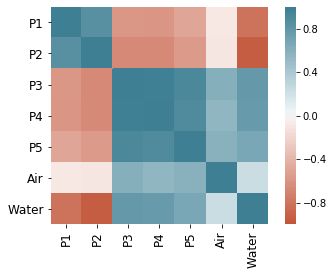

In [6]:
############################################# correlation matrix #############################################################
import pandas as pd
import seaborn as sns

#fig, ax = plt.subplots(figsize = (8, 8))
corr = df[df.columns[2:]].corr()
ticks = ['P1', 'P2', 'P3', 'P4', 'P5', 'Air', 'Water']
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ticks,fontsize = 12)
ax.set_yticklabels(ticks, fontsize = 12)

<font color=blue>**Discussion**</font>

1. P3 and P4 looks highly correlated
2. P2 and water flow rate are anti-correlated

In [12]:
####################################################### 1-D analysis #######################################################

###################### Piecewise Linear Function 
print('Piecewise:\n')
from sklearn.linear_model import LinearRegression
#to reduce computing time use every 3rd data point

def piecewise_linear(x_train, x_test=None):
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = max(0, x_test[i] - x_train[j])
    return X

#X_train_pl = []
for i in range(X_train_3rd.shape[1]):
    X_train_pl = piecewise_linear(X_train_3rd[:,i])
    X_train_pl[:, -1] += 1                        #makes column of 1s at the end => equivalent of adding an intercept
    
    model = LinearRegression(fit_intercept = False) #create a linear regression model instance (no intercept needed)
    model.fit(X_train_pl, y_train_3rd)                    

    X_test_pl = piecewise_linear(X_train_3rd[:,i], X_test[:,i])
    yhat = model.predict(X_test_pl)
    
    r2_train = model.score(X_train_pl,y_train_3rd)
    r2_test = model.score(X_test_pl,y_test)
    print('For {} the Training r^2 = {}, Test r^2 = {}'.format(x_names[i], r2_train, r2_test))


############################## Radial Basis Function Kernel 
print('\n\nRBF kernel:\n')
#to reduce computing time use every 3rd training data point for development
X_train_3rd = X_train[::3]
y_train_3rd = y_train[::3]

def rbf(x_train, x_test = None, gamma = 0.01):
    if x_test is None:
        x_test = x_train
    N = len(x_test)
    M = len(x_train)
    X = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            X[i, j] = np.exp(-gamma * (x_test[i] - x_train[j])**2)       
    return X


for k in range(X_train_3rd.shape[1]):
    X_train_rbf = rbf(X_train_3rd[:,k], x_test = None)

    model = LinearRegression()
    model.fit(X_train_rbf, y_train_3rd)

    X_test_rbf = rbf(X_train_3rd[:,k], X_test[:,k])
    yhat = model.predict(X_test_rbf)

    r2_train = model.score(X_train_rbf,y_train_3rd)
    r2_test = model.score(X_test_rbf,y_test)
    #print('Gamma = {}'.format(gamma))
    print('For {} the Training r^2 = {}, Test r^2 = {}'.format(x_names[k], r2_train, r2_test))

Piecewise:

For P1 (kPa) the Training r^2 = 0.948216818147167, Test r^2 = 0.02488389655696921
For P2 (kPa) the Training r^2 = 0.994877317985972, Test r^2 = 0.43960661669997625
For P3 (kPa) the Training r^2 = 0.9978162068871687, Test r^2 = 0.37306241526573325
For P4 (kPa) the Training r^2 = 0.9963873294270864, Test r^2 = 0.39106739999709306
For P5 (kPa) the Training r^2 = 0.9966890294994725, Test r^2 = 0.1620978874480805
For Air Flow (L/s) the Training r^2 = 0.9408448141901364, Test r^2 = -43.50307097107742
For Water Flow (L/s) the Training r^2 = 0.8026610407630139, Test r^2 = 0.5081580124758786


RBF kernel:

For P1 (kPa) the Training r^2 = 0.16234291670392975, Test r^2 = 0.14261051564341076
For P2 (kPa) the Training r^2 = 0.453878112491484, Test r^2 = 0.4538181495707143
For P3 (kPa) the Training r^2 = 0.5240796404095776, Test r^2 = 0.5211653949036189
For P4 (kPa) the Training r^2 = 0.47017566280052986, Test r^2 = 0.48207406237934763
For P5 (kPa) the Training r^2 = 0.4861044336830962, 

<font color=blue>**Discussion**</font>

1. Piecewise linear model gives good $r^2$ on training set, but not for test set
2. RBF kernel model need further hyperparameter tuning to give better performence
3. The score for both non-parametric models are not good, indicating single feature is not enough for prediction 

## 3. Baseline model



Training r^2 = 0.6098440381618748, Test r^2 = 0.5857735916224023




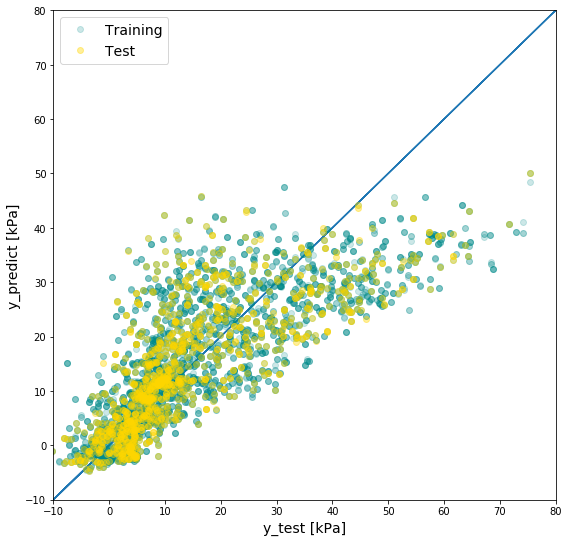

In [8]:
########################################## Baseline model 1 #################################################################

######################### multi-linear regression
from sklearn.linear_model import LinearRegression

model = LinearRegression() 
model.fit(X_train,y_train)
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

r2_train = model.score(X_train,y_train)
r2_test = model.score(X_test,y_test)

print('\n\nTraining r^2 = {}, Test r^2 = {}\n\n'.format(r2_train, r2_test))

fig, ax = plt.subplots(figsize = (9, 9))
ax.plot(y_test, y_test, '-')
ax.plot(y_train, y_hat_train, 'o', label = 'Training', color='darkcyan', alpha = 0.2)
ax.plot(y_test, y_hat_test, 'o', label = 'Test', color='gold', alpha = 0.4)
plt.xlim(-10, 80)
plt.ylim(-10, 80)
ax.set_xlabel('y_test [kPa]', fontsize = 14)
ax.set_ylabel('y_predict [kPa]', fontsize = 14)
plt.legend(loc = 2, fontsize = 14)



Optimum Alpha = 0.001, Optimum Sigma = 0.01

Training r^2 = 0.609843302649187, Test r^2 = 0.585830002874164




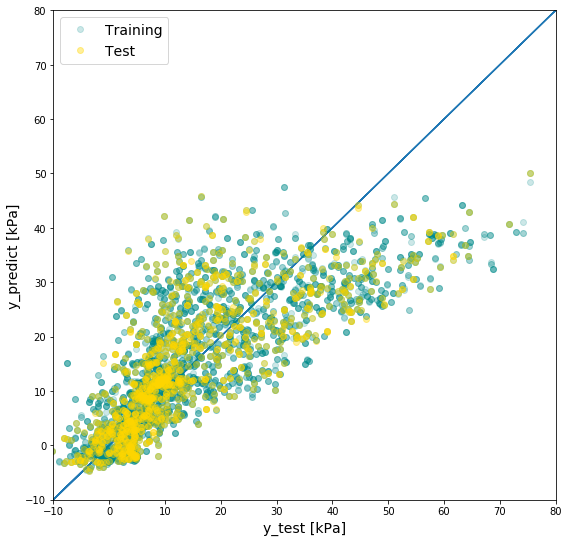

In [10]:
########################################## Baseline model 3 #################################################################
# Lasso Regression - L1 norm regularization
from sklearn.linear_model import Lasso

alphas = np.array([1e-9, 1e-7, 1e-5, 1e-3])
sigmas = np.array([0.01, 0.05, 0.1, 0.25, 0.5])

findAlpha =[]
for alpha in alphas:
    findSigma = []
    for sigma in sigmas:
        gamma = 1. / 2 / sigma**2
        lasso = Lasso(alpha = alpha)
        
        lasso.fit(X_train, y_train)
        r2 = lasso.score(X_test, y_test)
        
        findSigma.append(r2)
    
    optSigmaIndex = findSigma.index(max(findSigma))
    suboptSigma = sigmas[optSigmaIndex]
    submaxR2 = max(findSigma)
    
    findAlpha.append((submaxR2, suboptSigma))
    
optAlphaIndex = findAlpha.index(max(findAlpha))
optAlpha = alphas[optAlphaIndex]
optSigma = findAlpha[optAlphaIndex][1]
maxR2 = findAlpha[optAlphaIndex][0]
print('\n\nOptimum Alpha = {}, Optimum Sigma = {}'.format(optAlpha, optSigma))

lasso = Lasso(alpha = alpha)
lasso.fit(X_train, y_train)
r2_test = lasso.score(X_test, y_test)
r2_train = lasso.score(X_train, y_train)
print('\nTraining r^2 = {}, Test r^2 = {}\n\n'.format(r2_train, r2_test))

# Technically improper to scale prior to GridSearchCV
# Optimum alpha & Sigma just go to lowest of range; negligible r2 impact
# Adding zero to alpha matrix causes nonconvergence errors

y_hat_test = lasso.predict(X_test)
y_hat_train = lasso.predict(X_train)

fig, ax = plt.subplots(figsize = (9, 9))
ax.plot(y_test, y_test, '-')
ax.plot(y_train, y_hat_train, 'o', label = 'Training', color='darkcyan', alpha = 0.2)
ax.plot(y_test, y_hat_test, 'o', label = 'Test', color='gold', alpha = 0.4)
plt.xlim(-10, 80)
plt.ylim(-10, 80)
ax.set_xlabel('y_test [kPa]', fontsize = 14)
ax.set_ylabel('y_predict [kPa]', fontsize = 14)
plt.legend(loc = 2, fontsize = 14)



Optimum Alpha = 0.01, Optimum Gamma = 2.0

Training r^2 = 0.9841560401824924, Test r^2 = 0.9545949708175125




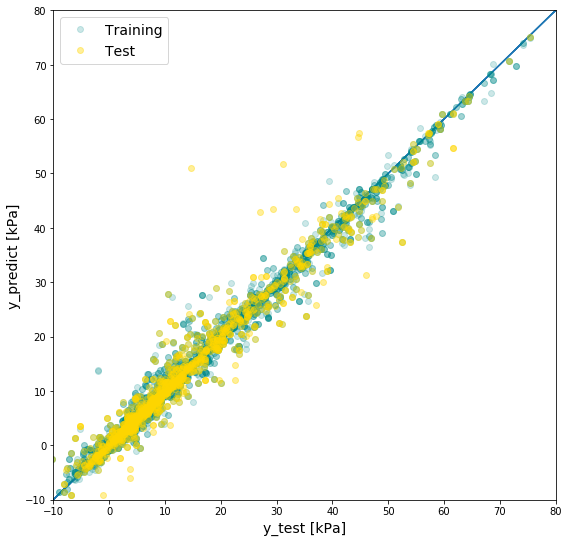

In [9]:
########################################## Baseline model 2 #################################################################
###################### Kernel Ridge Regression - l2 norm regularization
from sklearn.model_selection import GridSearchCV
alphas = np.array([1e-3, 1e-2, 1e-1])
sigmas = np.array([0.25, 0.5, 0.75])
gammas = 1. / 2 / sigmas**2

from sklearn.kernel_ridge import KernelRidge
KRRparam_grid = {'alpha':alphas, 'gamma':gammas}
KRR = KernelRidge(kernel = 'rbf')
KRR_search = GridSearchCV(KRR, KRRparam_grid, cv = 3)
# Line below runs slowly, tried to optimize param grid some to speed up
KRR_search.fit(X_train, y_train)

optAlpha = KRR_search.best_estimator_.alpha
optGamma = KRR_search.best_estimator_.gamma
#optSigma = np.sqrt(1. / 2 / optGamma)
r2_train = KRR_search.best_estimator_.score(X_train, y_train)
r2_test = KRR_search.best_estimator_.score(X_test, y_test)
print('\n\nOptimum Alpha = {}, Optimum Gamma = {}'.format(optAlpha, optGamma))
print('\nTraining r^2 = {}, Test r^2 = {}\n\n'.format(r2_train, r2_test))

model = KernelRidge(alpha = 0.01, kernel = 'rbf', gamma=2).fit(X_train, y_train)
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

fig, ax = plt.subplots(figsize = (9, 9))
ax.plot(y_test, y_test, '-')
ax.plot(y_train, y_hat_train, 'o', label = 'Training', color='darkcyan', alpha = 0.2)
ax.plot(y_test, y_hat_test, 'o', label = 'Test', color='gold', alpha = 0.4)
plt.xlim(-10, 80)
plt.ylim(-10, 80)
ax.set_xlabel('y_test [kPa]', fontsize = 14)
ax.set_ylabel('y_predict [kPa]', fontsize = 14)
plt.legend(loc = 2, fontsize = 14)

<font color=blue>**Discussion**</font>

1. Training data set and test data set have comparable $R^2$
2. Multilinear regression and LASSO tend to underestimated P6 in the high pressure ragion
3. Heteroscedasticity error
4. KRR modle is best
5. Will add time series in future

## 4. Time-series
In the following section, we will give a preview of using time-series model. Intuitively, our database: the two-phase flow correlation should not be time-dependent. However the reason we incorprate time series model here lies in: 1. the trasition state between two steady state is time-depedent, and thus we would like to see the time-dependent effect in short term; 2. make sure the design of experiment is reasonable and there is no long-term time dependency.

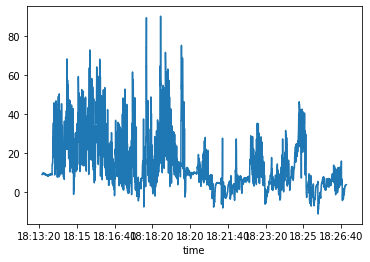

In [13]:
# data vitulization 
pd.plotting.register_matplotlib_converters()
plt.plot(df[df.columns[0]],y)

[1.         0.92644135 0.85288225 0.77932315 0.70576406 0.69353974
 0.6813155  0.66909127 0.65686703 0.65404314 0.65121926 0.64839538
 0.6455715  0.63804791 0.63052376 0.62299961 0.61547546 0.60984241
 0.60420917 0.59857593 0.59294269]


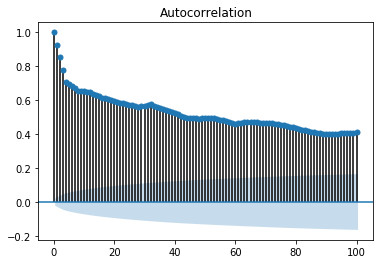

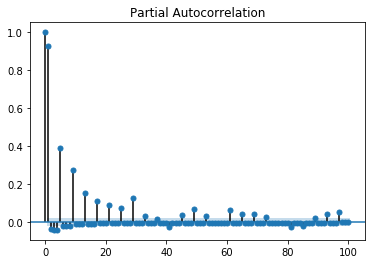

In [14]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

autocorr = acf(y, nlags = 20,fft=False)
print(autocorr)
_ = plot_acf(y, lags = 100)
_ = plot_pacf(y, lags = 100)

We see that the our dataset is actually astonishingly autocorrelated past 100 prior points, although the autocorrelation decays rapidly. The partial autocorrelation falls off quickly, with only 2 prior points having significant partial autocorrelations, and no long-term seasonal variations are visisble. This make senses because we expect the system reaches equilibrium relatively quick. Also we see some scatter data points priorer than 5 steps also have high partial correlation, this probably due to the experiment design flaw. 


Overall, this is just a sample test for the incorpration of time-series theory while more details will be potentially included in the following report.